# References:  
- Parts of this notebook were influenced by publicly shared Kaggle notebooks, online tutorials, and open-source libraries.  
- I appreciate the Kaggle community and open-source contributors for providing helpful insights and code examples that guided this work. 

# Module

In [1]:
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error

import optuna
from lightgbm import LGBMRegressor, early_stopping

import warnings

warnings.filterwarnings("ignore")

In [2]:
%matplotlib inline
plt.style.use('ggplot')

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

In [3]:
# Set random seed for reproducibility
SEED=42
np.random.seed(SEED)
random.seed(SEED)

# Data

In [4]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

combined = pd.concat([train, test], axis=0, ignore_index=True)

In [5]:
train.head()

,id,date,country,store,product,num_sold
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0


In [6]:
train.shape, test.shape

((230130, 6), (98550, 5))

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230130 entries, 0 to 230129
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   id        230130 non-null  int64  
 1   date      230130 non-null  object 
 2   country   230130 non-null  object 
 3   store     230130 non-null  object 
 4   product   230130 non-null  object 
 5   num_sold  221259 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 10.5+ MB


In [8]:
combined['date'] = pd.to_datetime(combined['date'])

# EDA

In [9]:
RMV = ["id", "num_sold"]
FEATURES = [c for c in combined.columns if not c in RMV]

CATS = []
HIGH_CARDINALITY = []
print(f"THE {len(FEATURES)} BASIC FEATURES ARE:")

for c in FEATURES:
    ftype = str(combined[c].dtype)
    if combined[c].dtype=="object":
        CATS.append(c)
        ftype = "categorical"
        
    n = combined[c].nunique()
    print(f"{c} ({ftype}) with {n} unique values")
    if n>=5: HIGH_CARDINALITY.append(c)
    
train = combined.iloc[:len(train)].copy()
test = combined.iloc[len(train):].reset_index(drop=True).copy()

print("\nTHE FOLLOWING HAVE 5 OR MORE UNIQUE VALUES:", HIGH_CARDINALITY )

THE 4 BASIC FEATURES ARE:
date (datetime64[ns]) with 3652 unique values
country (categorical) with 6 unique values
store (categorical) with 3 unique values
product (categorical) with 5 unique values

THE FOLLOWING HAVE 9 OR MORE UNIQUE VALUES: ['date']


In [11]:
for col in CATS:
    print(f'\nTop value counts in "{col}" : \n{train[col].value_counts()}')


Top value counts in "country" : 
country
Canada       38355
Finland      38355
Italy        38355
Kenya        38355
Norway       38355
Singapore    38355
Name: count, dtype: int64

Top value counts in "store" : 
store
Discount Stickers       76710
Stickers for Less       76710
Premium Sticker Mart    76710
Name: count, dtype: int64

Top value counts in "product" : 
product
Holographic Goose     46026
Kaggle                46026
Kaggle Tiers          46026
Kerneler              46026
Kerneler Dark Mode    46026
Name: count, dtype: int64


### Observations on Categorical Columns

- **"country" Column:**  
  Each country (e.g., Canada, Finland, Italy) has the exact same number of entries (38,355). This uniform distribution is unusual and suggests the dataset might be artificially generated or sampled to maintain balance across categories.

- **"store" Column:**  
  Only three unique store names appear, each with an equal count of 76,710. This even distribution further supports the hypothesis that the data is synthetic and designed for balanced testing purposes.

- **"product" Column:**  
  The product names, such as "Holographic Goose" and "Kaggle Tiers," also have identical frequencies (46,026). These names seem whimsical and non-realistic, indicating the dataset likely serves as a placeholder or demo dataset rather than reflecting real-world data.

### Key Takeaway:
- The dataset's balanced and repetitive structure implies that it may not accurately represent real-world scenarios. Any modeling results should be interpreted cautiously, keeping in mind the synthetic nature of the data.

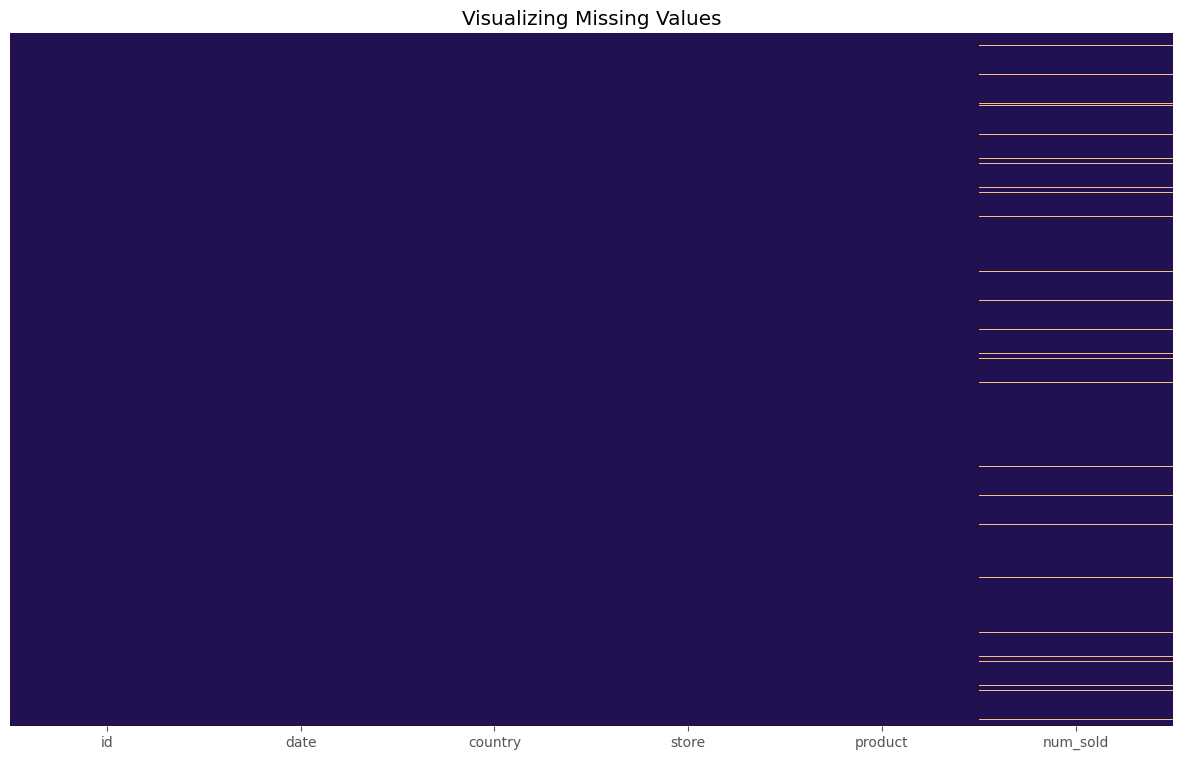

In [12]:
plt.figure(figsize=(15,9))
plt.title("Visualizing Missing Values")
sns.heatmap(train.isnull(), cbar=False, cmap=sns.color_palette('magma'), yticklabels=False);
plt.show()

### Missing Values Check

- It looks like there are no missing values in the features (`id`, `date`, `country`, `store`, `product`).  
- However, the target column (`num_sold`) does have some missing values.  

### Next Steps:
- I’ve already tried filling the missing values with 0, mean, and median, but the results weren’t great.  
- Moving forward, I’ll consider:  
  1. Dropping rows with missing targets.
  2. Building a separate model to predict the missing values before training the main model.  

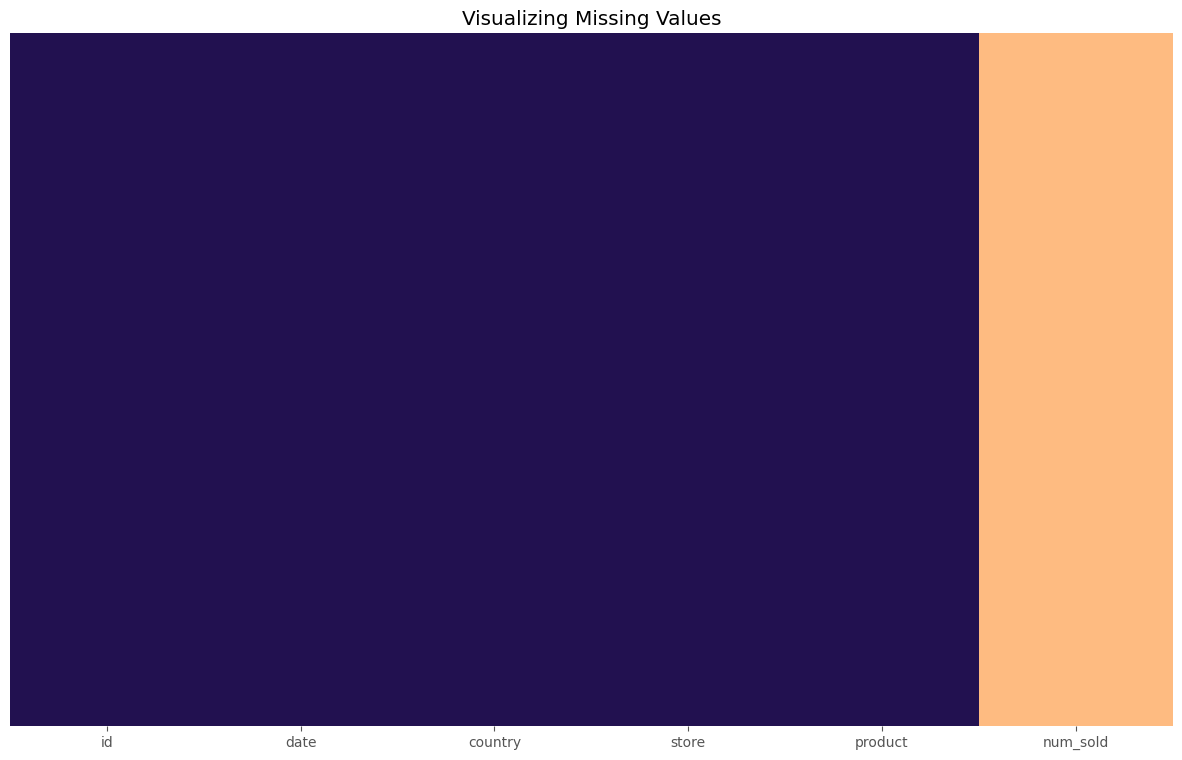

In [13]:
plt.figure(figsize=(15,9))
plt.title("Visualizing Missing Values")
sns.heatmap(test.isnull(), cbar=False, cmap=sns.color_palette('magma'), yticklabels=False);
plt.show()

In [14]:
df_nan = train[train['num_sold'].isnull()]
df_nan.head()

,id,date,country,store,product,num_sold
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN
45,45,2010-01-01,Kenya,Discount Stickers,Holographic Goose,NaN
90,90,2010-01-02,Canada,Discount Stickers,Holographic Goose,NaN
135,135,2010-01-02,Kenya,Discount Stickers,Holographic Goose,NaN
180,180,2010-01-03,Canada,Discount Stickers,Holographic Goose,NaN


In [15]:
for col in CATS:
    print(f'\nTop value counts in "{col}" : \n{df_nan[col].value_counts()}')


Top value counts in "country" : 
country
Kenya     4625
Canada    4246
Name: count, dtype: int64

Top value counts in "store" : 
store
Discount Stickers       5179
Stickers for Less       2666
Premium Sticker Mart    1026
Name: count, dtype: int64

Top value counts in "product" : 
product
Holographic Goose     8806
Kerneler                64
Kerneler Dark Mode       1
Name: count, dtype: int64


### Value Counts for Missing Target Data
- Missing targets seem concentrated in specific countries, stores, and products, indicating a pattern rather than random occurrence.  
- Analyze feature distributions within the missing target data to better understand potential causes.  
- Consider using different strategies for each group, especially the dominant "Holographic Goose" product category.  

In [16]:
print('nan count of "num_sold"', train.loc[(train['country']=='Kenya')&(train['store']=='Discount Stickers')&(train['product']=='Holographic Goose')]['num_sold'].isnull().sum())
print('Total Count', len(train.loc[(train['country']=='Kenya')&(train['store']=='Discount Stickers')&(train['product']=='Holographic Goose')]))

nan count of "num_sold" 2557
Total Count 2557


In [17]:
nan_summary = (
    train.groupby(['country', 'store', 'product'])
         .agg(
             NaN_Count=('num_sold', lambda x: x.isnull().sum()),  
             Total_Count=('num_sold', 'size')                     
         )
         .assign(NaN_Ratio=lambda x: (x['NaN_Count'] / x['Total_Count']) * 100)  
         .sort_values(by='NaN_Ratio', ascending=False)  
         .reset_index()
)

nan_summary.loc[nan_summary['NaN_Ratio']>0]

,country,store,product,NaN_Count,Total_Count,NaN_Ratio
0,Kenya,Discount Stickers,Holographic Goose,2557,2557,100.000000
1,Canada,Discount Stickers,Holographic Goose,2557,2557,100.000000
2,Kenya,Stickers for Less,Holographic Goose,1358,2557,53.109112
3,Canada,Stickers for Less,Holographic Goose,1308,2557,51.153696
4,Kenya,Premium Sticker Mart,Holographic Goose,646,2557,25.263981
5,Canada,Premium Sticker Mart,Holographic Goose,380,2557,14.861165
6,Kenya,Discount Stickers,Kerneler,63,2557,2.463825
7,Canada,Discount Stickers,Kerneler,1,2557,0.039108
8,Kenya,Discount Stickers,Kerneler Dark Mode,1,2557,0.039108


### Analysis of Missing Target Patterns

- The table above highlights specific patterns where missing target values (`num_sold`) are concentrated.  
- Key observations:
  1. Rows with **Kenya** and **Canada**, **Discount Stickers**, and **Holographic Goose** show **100% missing targets** (2,557 each).  
  2. Missing values are also relatively high (51–53%) for the same product in **Stickers for Less**.  
  3. For **Premium Sticker Mart**, the missing ratios are lower (14–25%), but still noticeable.  
  4. Other products, like **Kerneler** and **Kerneler Dark Mode**, have very few missing values (under 3%).  

### Decision:
- Since this is a baseline model, I’ve decided to **drop all rows with missing targets** to simplify the initial modeling process.  
- Future steps may involve experimenting with imputation or separate models for handling missing targets, especially for cases where missing values follow identifiable patterns.

In [18]:
def plot_transform(df, col):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
    sns.histplot(df[col], kde=True, ax=ax[0])
    ax[0].set_title(f'{col} Distribution Before Log Transformation', fontsize=14)
    skew_before = df[col].skew()
    ax[0].text(0.7, 0.9, f'Skewness: {skew_before:.2f}', transform=ax[0].transAxes, fontsize=12, color='red')

    sns.histplot(np.log1p(df[col]), kde=True, ax=ax[1])
    ax[1].set_title(f'{col} Distribution After Log Transformation', fontsize=14)
    skew_after = np.log1p(df[col]).skew()
    ax[1].text(0.7, 0.9, f'Skewness: {skew_after:.2f}', transform=ax[1].transAxes, fontsize=12, color='red')
    plt.show()

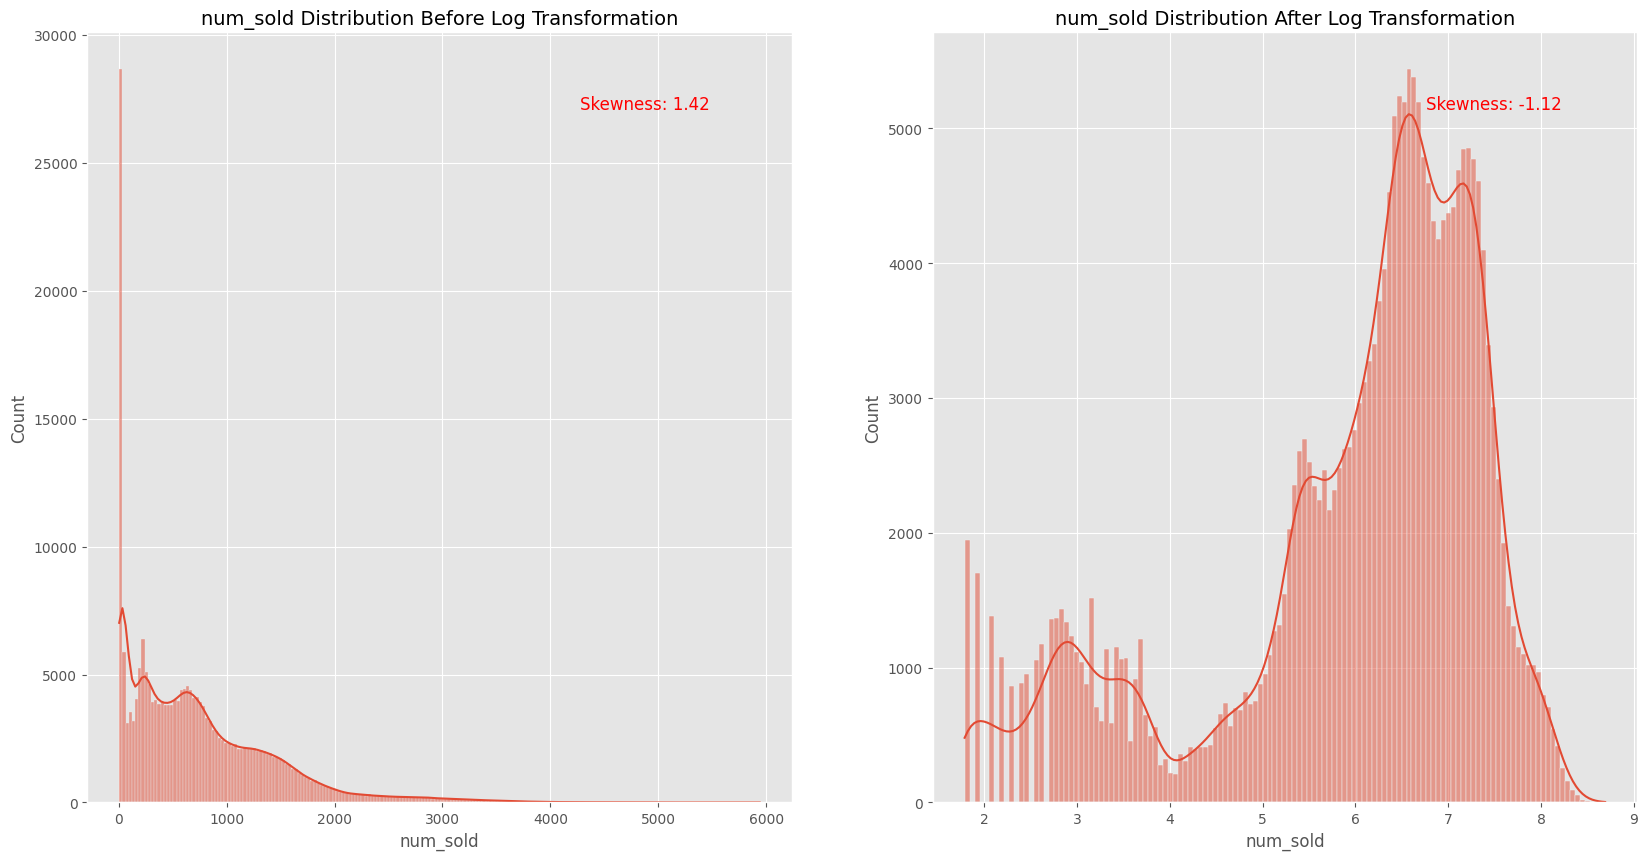

In [19]:
plot_transform(train, 'num_sold')

### Target Value Distribution Analysis 
- The target variable (`num_sold`) shows a **right-skewed distribution** with a skewness of **1.42**.  
- Applying a **log transformation** significantly reduces skewness to **-1.12**, resulting in a more **normalized distribution**.  
- For model training, the log-transformed target values were used to better handle skewness and improve performance.

In [20]:
def plot_cat_col(df, col):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(30, 10))

    sns.countplot(data=df, x=col, ax=ax[0], hue=col)
    ax[0].set_title(f'{col} Distribution')
    ax[0].set_xlabel(f'{col}')
    ax[0].set_ylabel('Count')
    
    sns.boxplot(data=df, x=col, y='num_sold', ax=ax[1], hue=col)
    ax[1].set_title(f'{col} Boxplot')
    ax[1].set_xlabel(f'{col}')

    plt.tight_layout()
    plt.show()

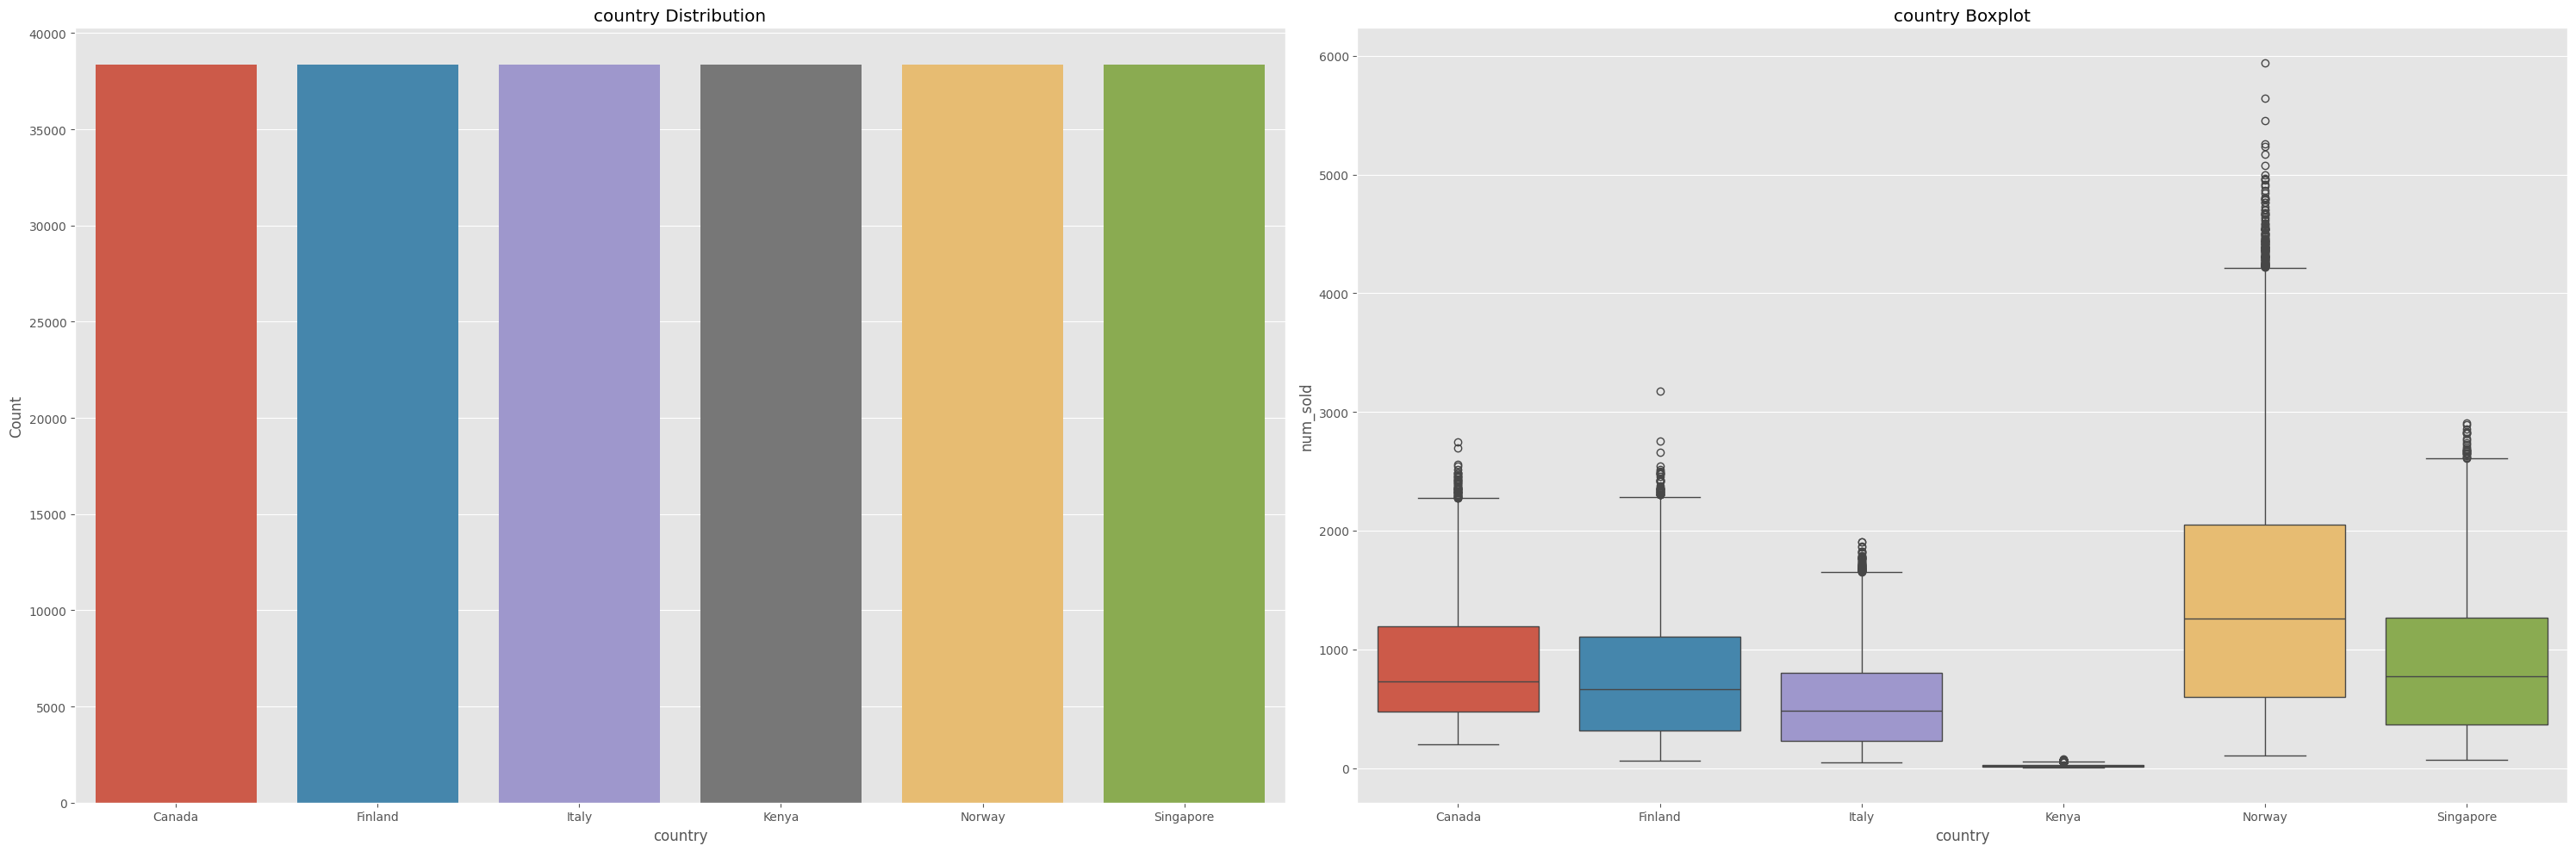

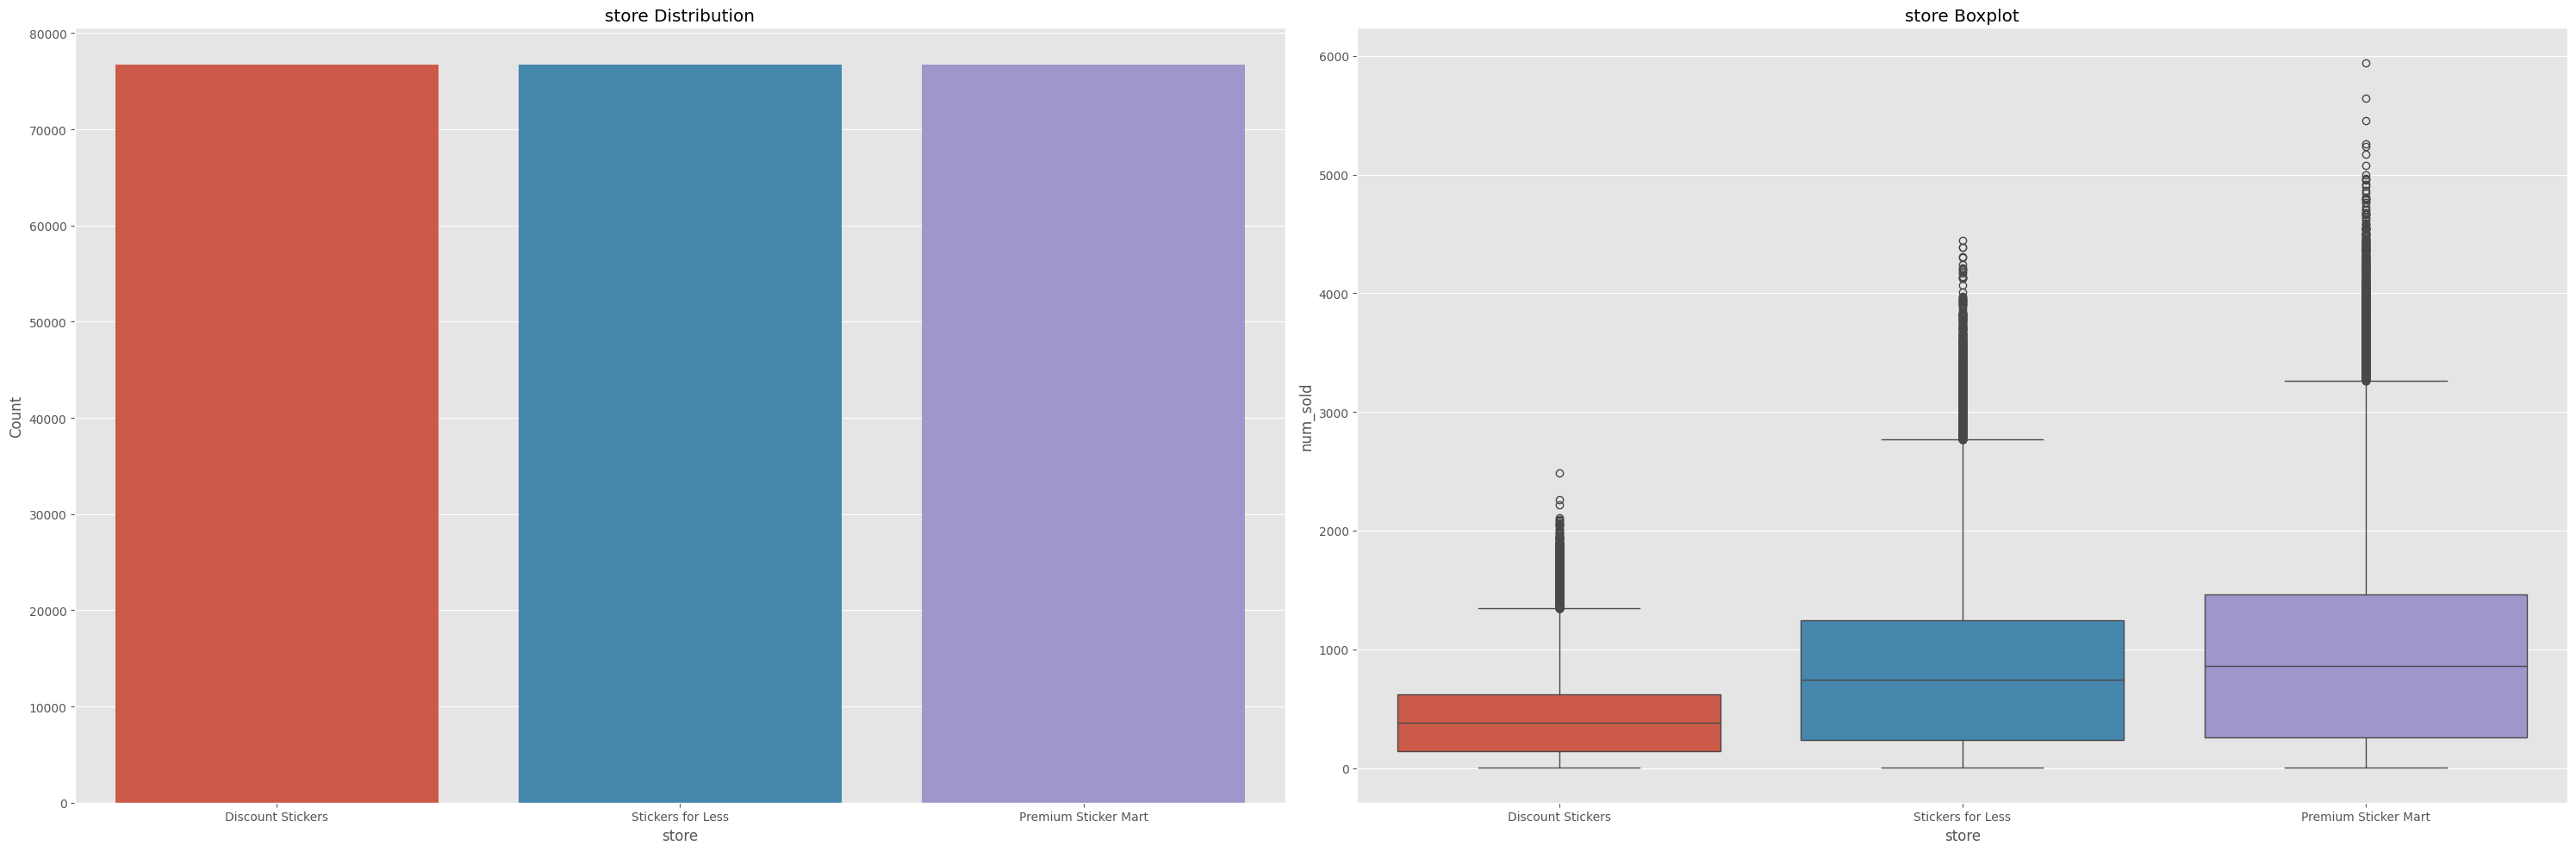

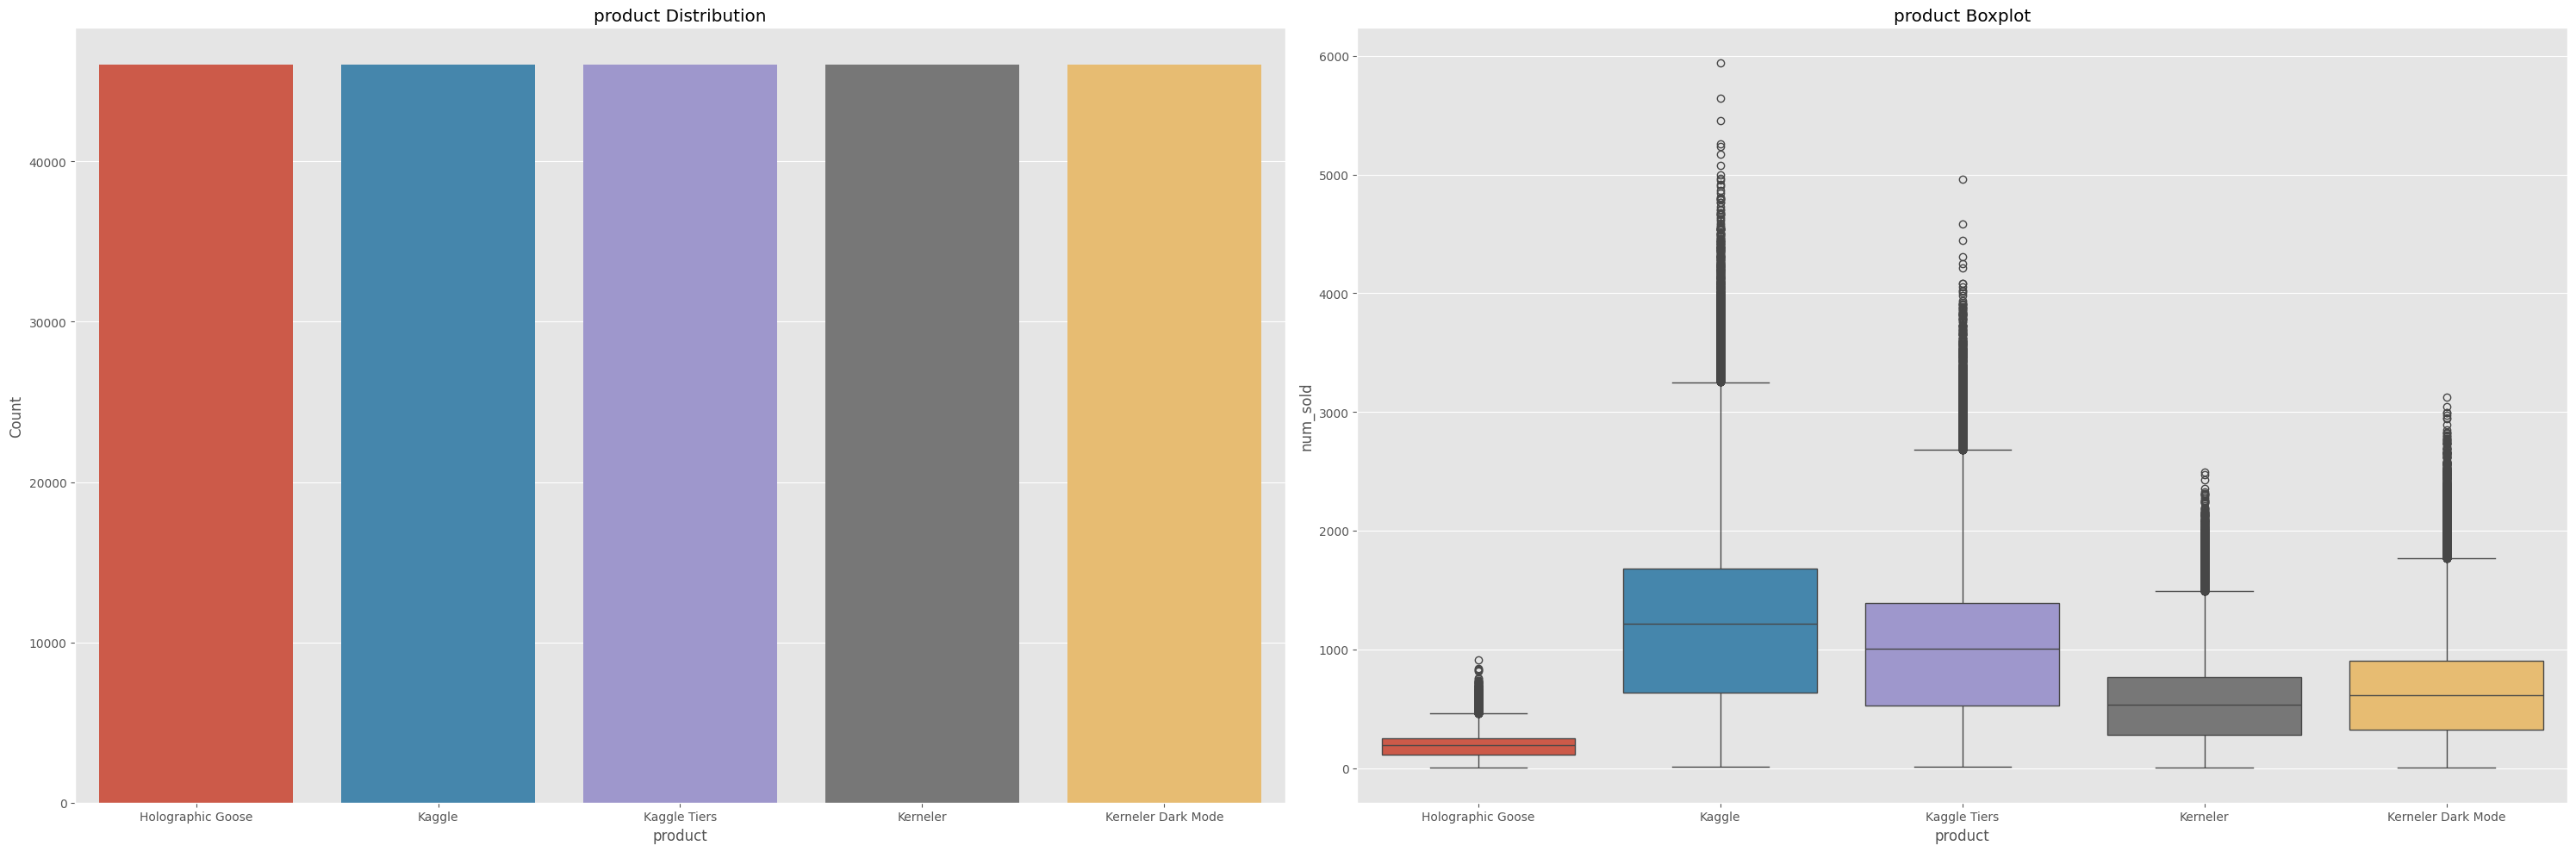

In [21]:
for col in CATS:
    plot_cat_col(train, col)

### Categorical Feature Insights
- Balanced Distribution in Categories
- Outliers in Target Values (`num_sold`)
- Distinct Patterns in Products and Stores

In [22]:
Q1 = train['num_sold'].quantile(0.25)
Q3 = train['num_sold'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = train[(train['num_sold'] < lower_bound) | (train['num_sold'] > upper_bound)]
print(f'Number of Outliers: {len(outliers)}')
print(f"Ratio of Outliers: {(len(outliers) / len(train['num_sold'])) * 100}%")

Number of Outliers: 6630
Ratio of Outliers: 2.8809803154738627%


# Date

In [23]:
# Extract date features (year, month, day, day of week)
def date(df):
    df['Year'] = df['date'].dt.year
    df['Day'] = df['date'].dt.day
    df['Month'] = df['date'].dt.month
    # df['Month_name'] = df['date'].dt.month_name()
    df['Day_of_week'] = df['date'].dt.day_name()
    df['Week'] = df['date'].dt.isocalendar().week
    df['Year_sin'] = np.sin(2 * np.pi * df['Year'])
    df['Year_cos'] = np.cos(2 * np.pi * df['Year'])
    min_year = df['Year'].min()
    max_year = df['Year'].max()
    df['Year_sin'] = np.sin(2 * np.pi * (df['Year'] - min_year) / (max_year - min_year))
    df['Year_cos'] = np.cos(2 * np.pi * (df['Year'] - min_year) / (max_year - min_year))
    df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12) 
    df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)
    df['Day_sin'] = np.sin(2 * np.pi * df['Day'] / 31)  
    df['Day_cos'] = np.cos(2 * np.pi * df['Day'] / 31)
    df['Group']=(df['Year']-2010)*48+df['Month']*4+df['Day']//7
    # df.drop('date', axis=1, inplace=True)
    return df

train = date(train)
test = date(test)
train.head()

,id,date,country,store,product,num_sold,Year,Day,Month,Day_of_week,Week,Year_sin,Year_cos,Month_sin,Month_cos,Day_sin,Day_cos,Group
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN,2010,1,1,Friday,53,0.0,1.0,0.5,0.866025,0.201299,0.97953,4
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0,2010,1,1,Friday,53,0.0,1.0,0.5,0.866025,0.201299,0.97953,4
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0,2010,1,1,Friday,53,0.0,1.0,0.5,0.866025,0.201299,0.97953,4
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0,2010,1,1,Friday,53,0.0,1.0,0.5,0.866025,0.201299,0.97953,4
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0,2010,1,1,Friday,53,0.0,1.0,0.5,0.866025,0.201299,0.97953,4


# Preprocessing

In [24]:
train = train.sort_values('date').reset_index(drop=True)

In [25]:
RMV = ['id', 'date', 'num_sold']
FEATURES = [c for c in train.columns if not c in RMV]
FEATURES

['country',
 'store',
 'product',
 'Year',
 'Day',
 'Month',
 'Day_of_week',
 'Week',
 'Year_sin',
 'Year_cos',
 'Month_sin',
 'Month_cos',
 'Day_sin',
 'Day_cos',
 'Group']

In [26]:
train = train.dropna()
train.shape

(221259, 18)

In [27]:
y = train['num_sold']

In [28]:
y.min(), y.max(), y.mean(), y.median(), y.isnull().sum()

(5.0, 5939.0, 752.527381937006, 605.0, 0)

In [41]:
CATS.append('Day_of_week')
label_encoders = {col: LabelEncoder() for col in CATS}

for col in CATS:
    train[col] = label_encoders[col].fit_transform(train[col])
    test[col] = label_encoders[col].transform(test[col])

In [47]:
test.head()

,id,date,country,store,product,num_sold,Year,Day,Month,Day_of_week,Week,Year_sin,Year_cos,Month_sin,Month_cos,Day_sin,Day_cos,Group
0,230130,2017-01-01,0,0,0,NaN,2017,1,1,3,52,0.0,1.0,0.5,0.866025,0.201299,0.97953,340
1,230131,2017-01-01,0,0,1,NaN,2017,1,1,3,52,0.0,1.0,0.5,0.866025,0.201299,0.97953,340
2,230132,2017-01-01,0,0,2,NaN,2017,1,1,3,52,0.0,1.0,0.5,0.866025,0.201299,0.97953,340
3,230133,2017-01-01,0,0,3,NaN,2017,1,1,3,52,0.0,1.0,0.5,0.866025,0.201299,0.97953,340
4,230134,2017-01-01,0,0,4,NaN,2017,1,1,3,52,0.0,1.0,0.5,0.866025,0.201299,0.97953,340


In [48]:
x = train.drop(['id', 'date', 'num_sold'], axis=1)
y = train['num_sold']
x_test = test.drop(['id', 'date', 'num_sold'], axis=1)
y_log = np.log1p(y)

# Model

## Hyperparmeter

In [44]:
%%time
def objective(trial):
    params = {
        "n_estimators": 300,
        "objective": "regression",
        "metric": "mape",
        "boosting_type": "gbdt",
        "num_leaves": trial.suggest_int("num_leaves", 10, 200),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 5, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 10, 100),
        "max_depth": trial.suggest_int("max_depth", -1, 12),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-4, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-4, 10.0, log=True),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0.001, 0.1),
        "device_type": "cpu",
        "seed" : SEED,
        'verbose':-1 # 경고 및 로그 메세지 출력 X

    }
    
    model = LGBMRegressor(**params)
    folds = KFold(n_splits=5, shuffle=True, random_state=SEED)
    scores = []

    for train_idx, val_idx in folds.split(x):
        x_train, x_val = x.iloc[train_idx], x.iloc[val_idx]
        y_train, y_val = y_log.iloc[train_idx], y_log.iloc[val_idx]

        model.fit(
            x_train, y_train,
            eval_set=[(x_val, y_val)],
            eval_metric='mape',
            callbacks=[early_stopping(100)]
        )
        preds = model.predict(x_val)
        mape = mean_absolute_percentage_error(y_val, preds)
        scores.append(mape)

    return np.mean(scores)

study = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.TPESampler(seed=SEED)
    )
study.optimize(objective, n_trials=5)

[I 2025-01-01 16:50:18,660] A new study created in memory with name: no-name-33076c0f-a5f6-4c3b-a550-68dd30046283


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[132]	valid_0's mape: 0.0165249
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[149]	valid_0's mape: 0.013308
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[110]	valid_0's mape: 0.012515
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[138]	valid_0's mape: 0.0188196
Training until validation scores don't improve for 100 rounds


[I 2025-01-01 16:50:25,169] Trial 0 finished with value: 0.014718387275085665 and parameters: {'num_leaves': 81, 'learning_rate': 0.07114476009343425, 'feature_fraction': 0.892797576724562, 'bagging_fraction': 0.8394633936788146, 'bagging_freq': 6, 'min_data_in_leaf': 24, 'max_depth': -1, 'lambda_l1': 2.1423021757741068, 'lambda_l2': 0.10129197956845731, 'min_gain_to_split': 0.07109918520180851}. Best is trial 0 with value: 0.014718387275085665.


Early stopping, best iteration is:
[154]	valid_0's mape: 0.0124244
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[274]	valid_0's mape: 0.0155096
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[294]	valid_0's mape: 0.0157823
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[299]	valid_0's mape: 0.0146489
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[300]	valid_0's mape: 0.0202191
Training until validation scores don't improve for 100 rounds


[I 2025-01-01 16:50:30,605] Trial 1 finished with value: 0.016637399637832527 and parameters: {'num_leaves': 13, 'learning_rate': 0.0812324508558869, 'feature_fraction': 0.9329770563201687, 'bagging_fraction': 0.6849356442713105, 'bagging_freq': 6, 'min_data_in_leaf': 26, 'max_depth': 3, 'lambda_l1': 0.042051564509138675, 'lambda_l2': 0.01444525102276306, 'min_gain_to_split': 0.029831684879606152}. Best is trial 0 with value: 0.014718387275085665.


Did not meet early stopping. Best iteration is:
[300]	valid_0's mape: 0.017027
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[300]	valid_0's mape: 0.286706
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[300]	valid_0's mape: 0.283452
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[300]	valid_0's mape: 0.28272
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[300]	valid_0's mape: 0.2794
Training until validation scores don't improve for 100 rounds


[I 2025-01-01 16:50:33,675] Trial 2 finished with value: 0.2807292792045272 and parameters: {'num_leaves': 126, 'learning_rate': 0.00026210878782654407, 'feature_fraction': 0.7168578594140873, 'bagging_fraction': 0.7465447373174767, 'bagging_freq': 8, 'min_data_in_leaf': 81, 'max_depth': 1, 'lambda_l1': 0.03725393839578886, 'lambda_l2': 0.09163741808778776, 'min_gain_to_split': 0.005598590859279775}. Best is trial 0 with value: 0.014718387275085665.


Did not meet early stopping. Best iteration is:
[300]	valid_0's mape: 0.271368
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[300]	valid_0's mape: 0.273258
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[300]	valid_0's mape: 0.269989
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[300]	valid_0's mape: 0.269211
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[300]	valid_0's mape: 0.26595
Training until validation scores don't improve for 100 rounds


[I 2025-01-01 16:50:39,767] Trial 3 finished with value: 0.2672725098354075 and parameters: {'num_leaves': 126, 'learning_rate': 0.00032476735706274504, 'feature_fraction': 0.6260206371941118, 'bagging_fraction': 0.9795542149013333, 'bagging_freq': 12, 'min_data_in_leaf': 83, 'max_depth': 3, 'lambda_l1': 0.0003078651783619622, 'lambda_l2': 0.2637333993381525, 'min_gain_to_split': 0.04457509688022053}. Best is trial 0 with value: 0.014718387275085665.


Did not meet early stopping. Best iteration is:
[300]	valid_0's mape: 0.257954
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[300]	valid_0's mape: 0.172443
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[300]	valid_0's mape: 0.168077
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[300]	valid_0's mape: 0.166426
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[300]	valid_0's mape: 0.162719
Training until validation scores don't improve for 100 rounds


[I 2025-01-01 16:50:45,902] Trial 4 finished with value: 0.16508044690854798 and parameters: {'num_leaves': 33, 'learning_rate': 0.0030586566669785274, 'feature_fraction': 0.6137554084460873, 'bagging_fraction': 0.9637281608315128, 'bagging_freq': 7, 'min_data_in_leaf': 70, 'max_depth': 3, 'lambda_l1': 0.039841905944346875, 'lambda_l2': 0.05414413211338523, 'min_gain_to_split': 0.01930059109702718}. Best is trial 0 with value: 0.014718387275085665.


Did not meet early stopping. Best iteration is:
[300]	valid_0's mape: 0.155736
CPU times: user 53.1 s, sys: 344 ms, total: 53.4 s
Wall time: 27.2 s


In [45]:
study.best_params, study.best_value

({'num_leaves': 81,
  'learning_rate': 0.07114476009343425,
  'feature_fraction': 0.892797576724562,
  'bagging_fraction': 0.8394633936788146,
  'bagging_freq': 6,
  'min_data_in_leaf': 24,
  'max_depth': -1,
  'lambda_l1': 2.1423021757741068,
  'lambda_l2': 0.10129197956845731,
  'min_gain_to_split': 0.07109918520180851},
 0.014718387275085665)

## Train

In [60]:
%%time
best_params = {
'n_estimators': 1000,
'num_leaves': 81,
'learning_rate': 0.07114476009343425,
'feature_fraction': 0.892797576724562,
'bagging_fraction': 0.8394633936788146,
'bagging_freq': 6,
'min_data_in_leaf': 24,
'max_depth': -1,
'lambda_l1': 2.1423021757741068,
'lambda_l2': 0.10129197956845731,
'min_gain_to_split': 0.07109918520180851,
'random_state': SEED,
'verbose': -1,
'n_jobs': -1
}

models_lgb = []
lgbm_OOF = np.zeros(len(x))
lgbm_preds = np.zeros(len(x_test))
folds = KFold(n_splits=5, shuffle=True, random_state=SEED)

for train_idx, val_idx in folds.split(x):
    x_train, x_val = x.iloc[train_idx], x.iloc[val_idx]
    y_train, y_val = y_log.iloc[train_idx], y_log.iloc[val_idx]

    model = LGBMRegressor(**best_params)
    model.fit(
        x_train, y_train, 
        eval_set=[(x_val, y_val)],
        eval_metric='mape',
        callbacks=[early_stopping(100)])

    lgbm_OOF[val_idx] += model.predict(x_val)
    lgbm_preds += model.predict(x_test) / folds.n_splits
    models_lgb.append(model)

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[160]	valid_0's mape: 0.0091828	valid_0's l2: 0.00366925
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[164]	valid_0's mape: 0.00907726	valid_0's l2: 0.00360485
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[161]	valid_0's mape: 0.00896577	valid_0's l2: 0.00353715
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[159]	valid_0's mape: 0.00917985	valid_0's l2: 0.00367198
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[161]	valid_0's mape: 0.00913012	valid_0's l2: 0.00361122
CPU times: user 1min 3s, sys: 114 ms, total: 1min 3s
Wall time: 19.9 s


# Evaluation

In [61]:
y_true = np.expm1(y_log)
y_pred = np.expm1(lgbm_OOF)

mape = mean_absolute_percentage_error(y_log, lgbm_OOF)
mae = mean_absolute_error(y_log, lgbm_OOF)

print(f"\nPerformance Metrics:\n{'-'*25}")
print(f"MAPE: {mape:.4f}")
print(f"MAE: {mae:.4f}")


Performance Metrics:
-------------------------
MAPE: 0.0091
MAE: 0.0475


In [66]:
train.columns.to_list()

['id',
 'date',
 'country',
 'store',
 'product',
 'num_sold',
 'Year',
 'Day',
 'Month',
 'Day_of_week',
 'Week',
 'Year_sin',
 'Year_cos',
 'Month_sin',
 'Month_cos',
 'Day_sin',
 'Day_cos',
 'Group']

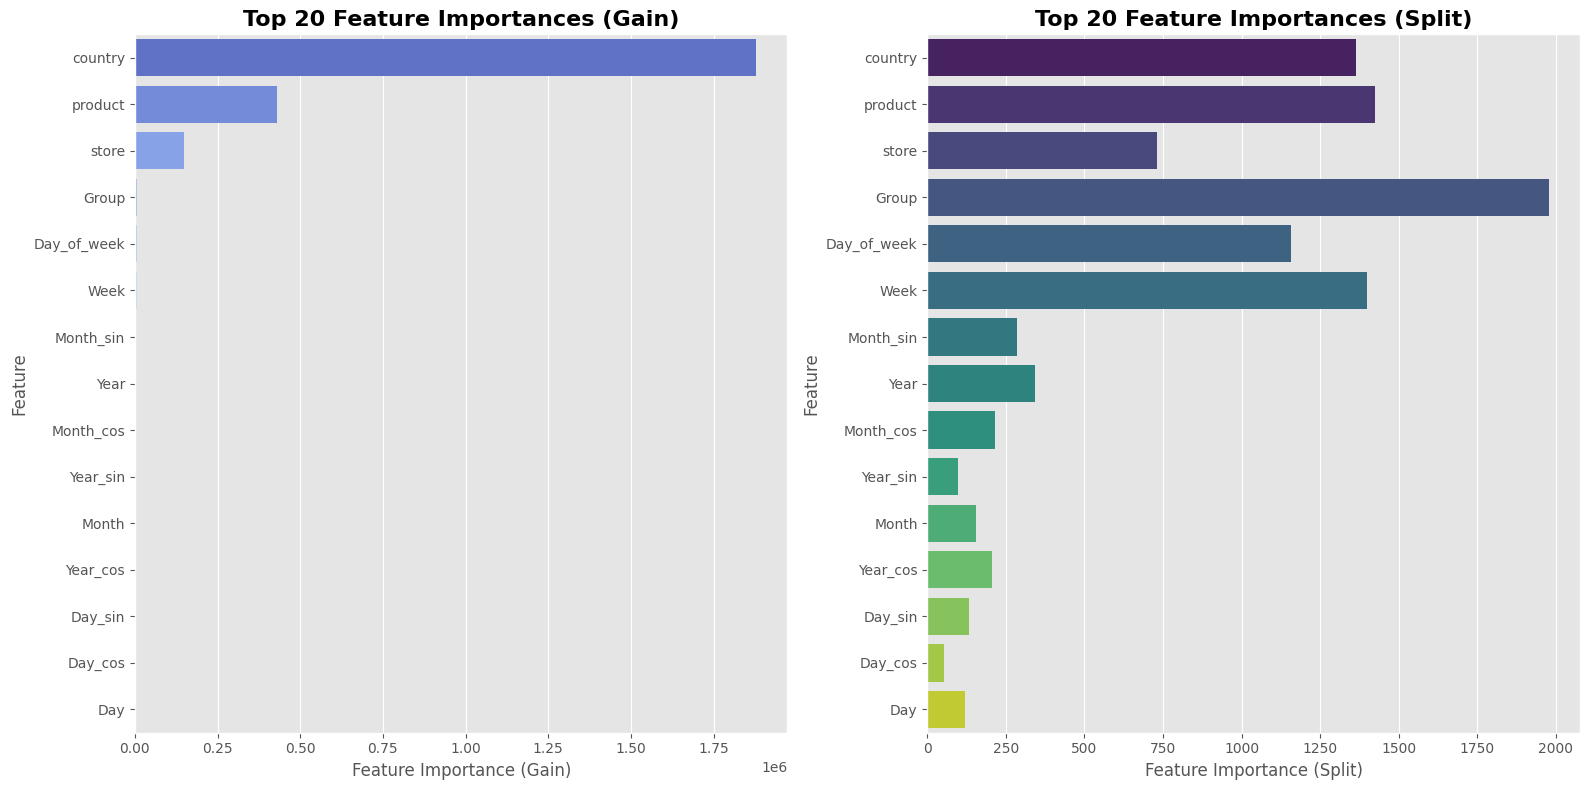

In [68]:
feature_names = models_lgb[0].booster_.feature_name()

importances_gain = np.zeros(len(feature_names))  # 'gain' 기준
importances_split = np.zeros(len(feature_names))  # 'split' 기준

for model in models_lgb:
    importances_gain += model.booster_.feature_importance(importance_type='gain')
    importances_split += model.booster_.feature_importance(importance_type='split')

importances_gain /= len(models_lgb)
importances_split /= len(models_lgb)

 
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Gain': importances_gain,
    'Split': importances_split
})

importance_df = importance_df.sort_values(by='Gain', ascending=False).reset_index(drop=True)
top_features = importance_df.head(20)

fig, axes = plt.subplots(1, 2, figsize=(16, 8)) 
plt.subplots_adjust(wspace=0.4) 

sns.barplot(data=top_features, x='Gain', y='Feature', ax=axes[0], palette="coolwarm")
axes[0].set_title("Top 20 Feature Importances (Gain)", fontsize=16, fontweight='bold')
axes[0].set_xlabel("Feature Importance (Gain)", fontsize=12)
axes[0].set_ylabel("Feature", fontsize=12)

sns.barplot(data=top_features, x='Split', y='Feature', ax=axes[1], palette="viridis")
axes[1].set_title("Top 20 Feature Importances (Split)", fontsize=16, fontweight='bold')
axes[1].set_xlabel("Feature Importance (Split)", fontsize=12)
axes[1].set_ylabel("Feature", fontsize=12)

plt.tight_layout()
plt.show()

- The dominance of `country` suggests strong regional effects, which may warrant further investigation into geographic patterns.  

# Submission

In [69]:
submission = pd.read_csv('./data/sample_submission.csv')
submission.head()

,id,num_sold
0,230130,100
1,230131,100
2,230132,100
3,230133,100
4,230134,100


In [71]:
preds = np.expm1(lgbm_preds)
submission['num_sold'] = preds
submission.head()

,id,num_sold
0,230130,140.529691
1,230131,911.526982
2,230132,755.959129
3,230133,398.759158
4,230134,477.818724


In [72]:
submission.to_csv('./data/01_baseline_submission.csv', index=False)
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions submit -c playground-series-s5e1 -f "./data/01_baseline_submission.csv" -m "01_baseline_02"

100%|██████████████████████████████████████| 2.38M/2.38M [00:00<00:00, 8.27MB/s]
Successfully submitted to Forecasting Sticker Sales

> 1st Sub (2/129)
- OOF : 0.0091
- LB : 0.10806